In [ ]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
gdd.download_file_from_google_drive(file_id='1nVCwSd-PLqRAEpzh68NXmXknDJD7F1eO', dest_path= '/data/AirQualityUCI.xlsx')

In [ ]:
df = pd.read_excel('/data/AirQualityUCI.xlsx')

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [ ]:
df.shape

(9357, 15)

In [ ]:
#converting date and time to datetime

df['Datetime']=df.Date+' '+df.Time
df['Time']=pd.to_datetime(df.Datetime)
df.dtypes

Date                     object
Time             datetime64[ns]
CO(GT)                   object
PT08.S1(CO)               int64
NMHC(GT)                  int64
C6H6(GT)                 object
PT08.S2(NMHC)             int64
NOx(GT)                   int64
PT08.S3(NOx)              int64
NO2(GT)                   int64
PT08.S4(NO2)              int64
PT08.S5(O3)               int64
T                        object
RH                       object
AH                       object
Datetime                 object
dtype: object

In [ ]:
#removing date and datetime 

df.drop('Date', axis=1, inplace=True)
df.drop('Datetime', axis=1, inplace=True)

In [ ]:
#We have numeric values separated with ',' so pandas understands it as type object. I replace ',' with '.' to make them float
dot_change = ['CO(GT)', 'C6H6(GT)', 'T','RH','AH']
for col in dot_change:
    df[col] = df[col].str.replace(',', '.').astype(float)

In [ ]:
#-200 means missing data so I replace it with NaN
df.replace(to_replace= -200, value= np.NaN, inplace= True)

In [ ]:
def filling_spaces(col):
    df[col] = df.groupby('Time')[col].transform(lambda x:x.fillna(x.mean()))


In [ ]:
#filing empty spaces with the mean
col_list = df.columns[1:12]

for i in col_list:
    filling_spaces(i)

In [ ]:
#percentage of missing values in each column in the given dataset

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
NMHC(GT),8443,90.231912
CO(GT),1683,17.986534
NO2(GT),1642,17.548360
NOx(GT),1639,17.516298
PT08.S1(CO),366,3.911510
C6H6(GT),366,3.911510
PT08.S2(NMHC),366,3.911510
PT08.S3(NOx),366,3.911510
PT08.S4(NO2),366,3.911510
PT08.S5(O3),366,3.911510


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           9357 non-null   datetime64[ns]
 1   CO(GT)         7674 non-null   float64       
 2   PT08.S1(CO)    8991 non-null   float64       
 3   NMHC(GT)       914 non-null    float64       
 4   C6H6(GT)       8991 non-null   float64       
 5   PT08.S2(NMHC)  8991 non-null   float64       
 6   NOx(GT)        7718 non-null   float64       
 7   PT08.S3(NOx)   8991 non-null   float64       
 8   NO2(GT)        7715 non-null   float64       
 9   PT08.S4(NO2)   8991 non-null   float64       
 10  PT08.S5(O3)    8991 non-null   float64       
 11  T              8991 non-null   float64       
 12  RH             8991 non-null   float64       
 13  AH             8991 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1023.5 KB


In [ ]:
#NMHC(GT) has too much missing values I guess I can drop it
df.drop('NMHC(GT)', axis=1, inplace=True)

In [ ]:
#Fill missing values with the last observed non-null value
df.fillna(method='ffill', inplace= True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           9357 non-null   datetime64[ns]
 1   CO(GT)         9357 non-null   float64       
 2   PT08.S1(CO)    9357 non-null   float64       
 3   C6H6(GT)       9357 non-null   float64       
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 950.4 KB


In [ ]:
#Feature's distribution
for column in df:
    plt.figure(figsize=(12, 6))
    print(column.title())
    sns.distplot(x = df[column], bins=30)
    plt.show()

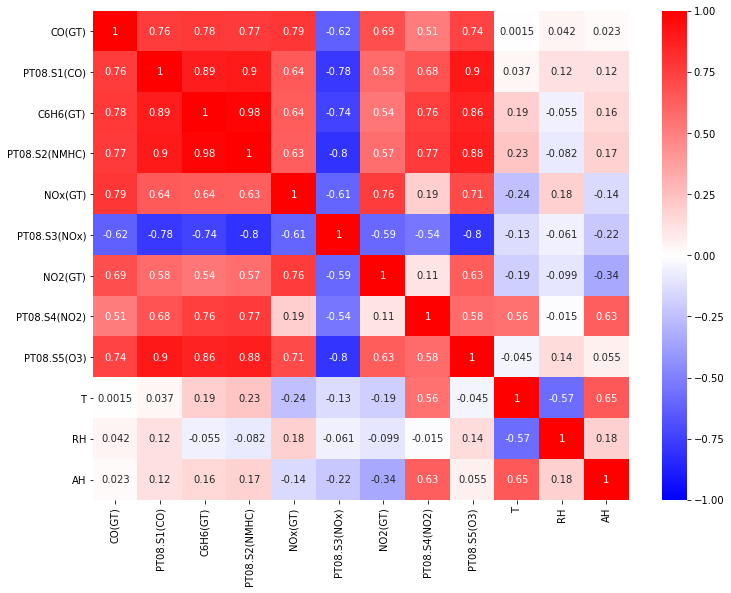

In [ ]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='bwr', annot = True)
plt.show()

If we look at the heatmap we will see that target variable C6H6 is positively correlated with T, AH and RH. Also variables such as PT08.S5(O3) and PT08.S1(CO), PT08.S5(O3) and PT08.S3(NOx), ... , are correlated which means multicollinearity.

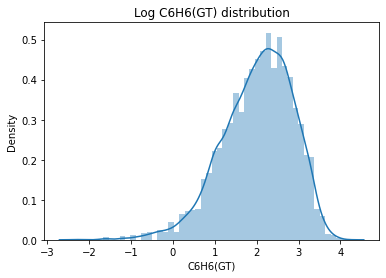

In [ ]:
#Normalization of target variable
ax = sns.distplot(np.log(df['C6H6(GT)']), norm_hist=True)
ax.set_title('Log C6H6(GT) distribution');

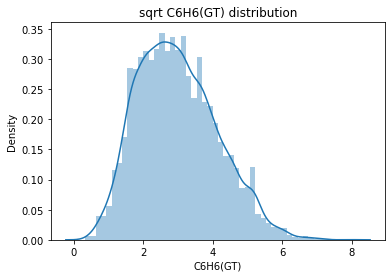

In [ ]:
ax = sns.distplot(np.sqrt(df['C6H6(GT)']), norm_hist=True)
ax.set_title('sqrt C6H6(GT) distribution');

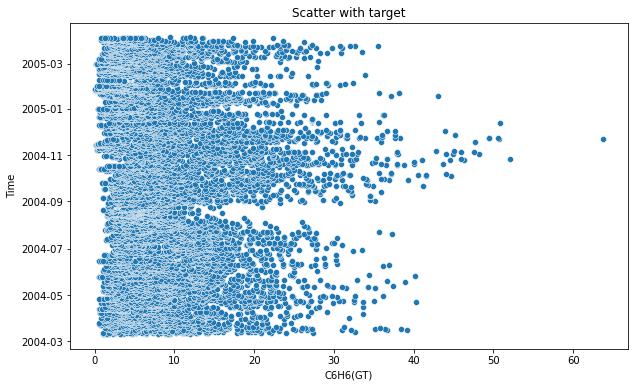

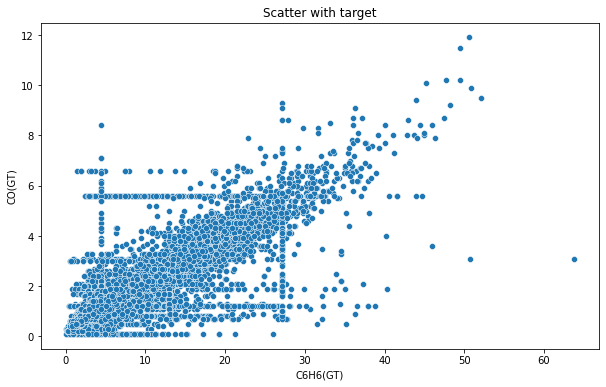

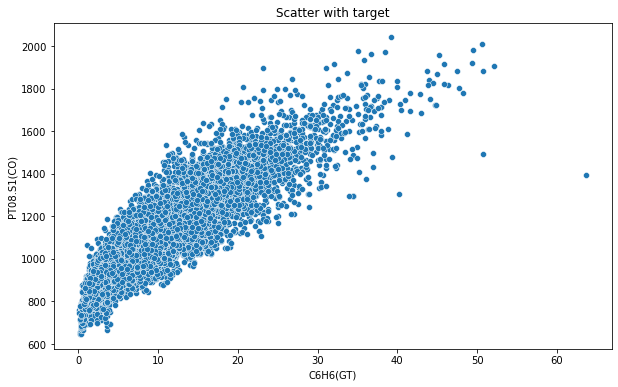

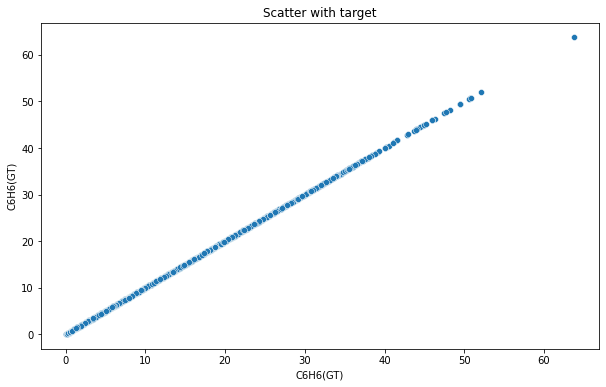

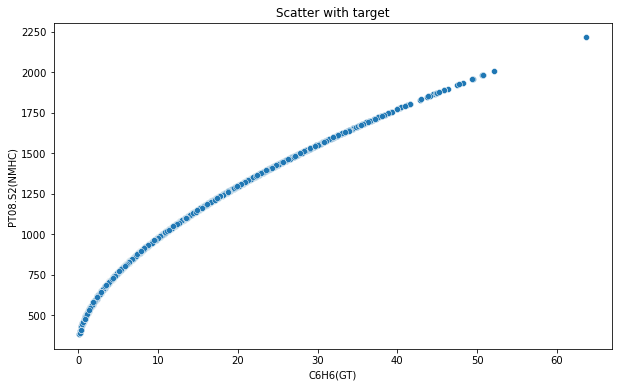

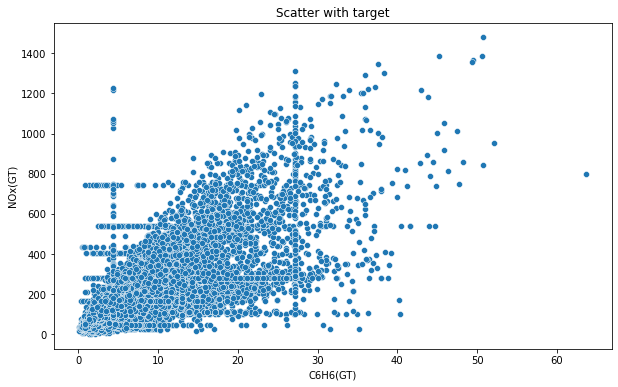

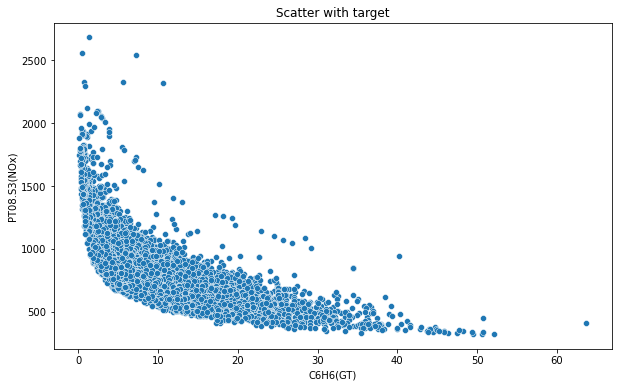

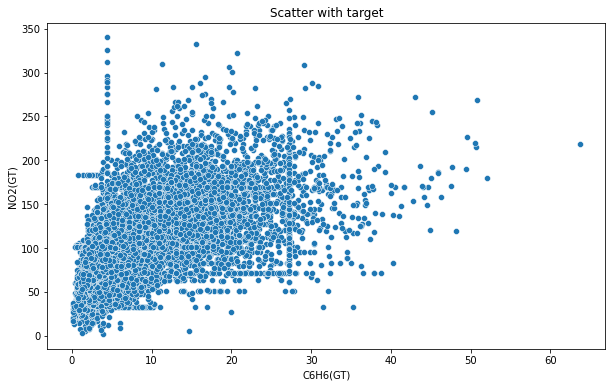

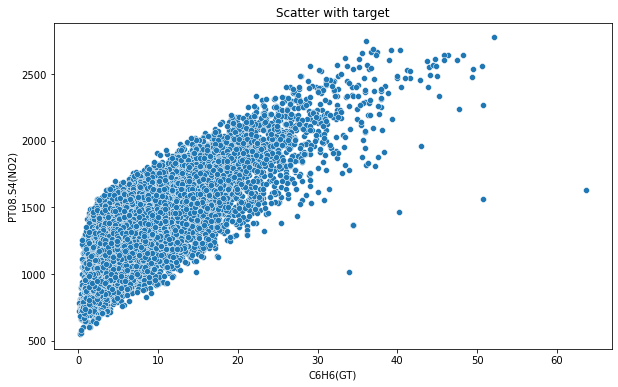

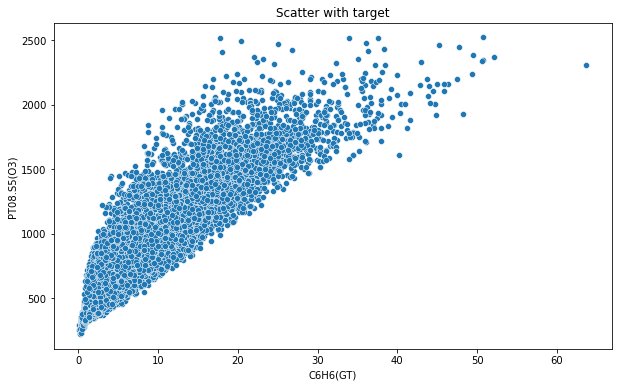

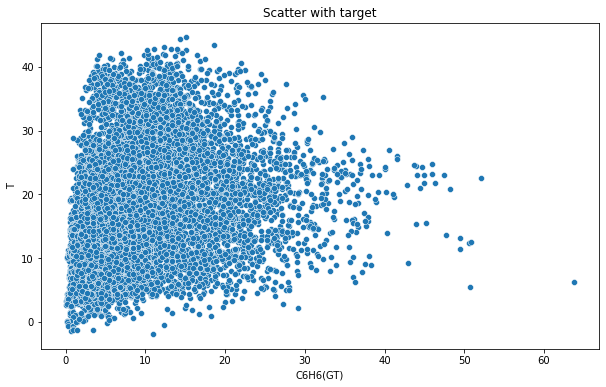

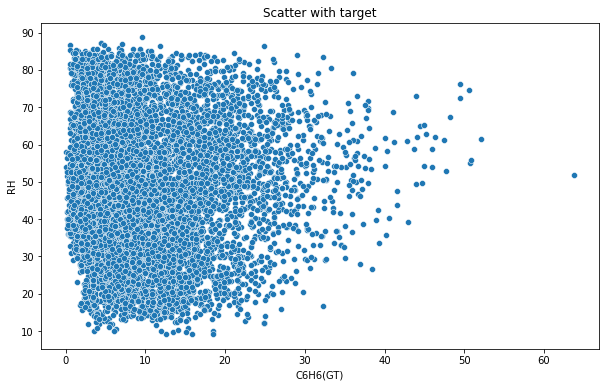

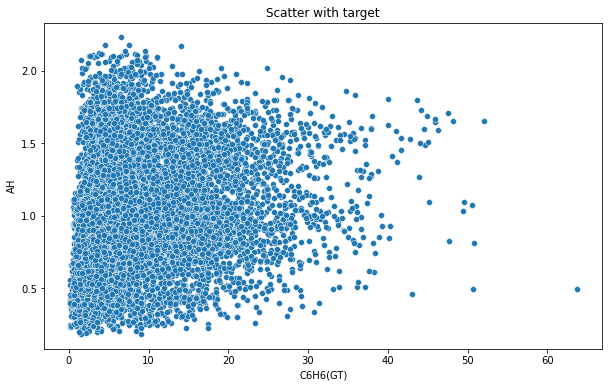

In [ ]:
for i in df:
    df = df[df[i] != -200]
    
for col in df:
    plt.figure(figsize = (10, 6))
    plt.title('Scatter with target')
    sns.scatterplot(data=df, x=df['C6H6(GT)'], y=col)
    plt.show()
#Scatter plot with target variable

In [ ]:
#Creating Linear Model
X=df[['CO(GT)', 'PT08.S1(CO)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']]
y=df[['C6H6(GT)']]

In [ ]:
#80% to the training set, 20% to the tessting set
X_train, X_test, Y_train, Y_test=train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
#Normalization of target variable in training set and It's plot
#Y_train = np.log(Y_train)
#ax = sns.distplot((Y_train), norm_hist=True)
#ax.set_title('sqrt C6H6(GT) distribution');

#When I do this I get negative R^2, it would be pleasant If you explain me why 

In [ ]:
#Data Dimension
X_train.shape, Y_train.shape

((7485, 11), (7485, 1))

In [ ]:
X_test.shape, Y_test.shape

((1872, 11), (1872, 1))

In [ ]:
model = LinearRegression(normalize="Boolean")

In [ ]:
model.fit(X_train, Y_train)

LinearRegression(normalize='Boolean')

In [ ]:
Y_prediction = model.predict(X_test)

    Alright! Model has been built. Now let's take a look at coefficients, Intercept, MSE, MAE, RMSE and R^2 

In [ ]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'% mean_squared_error(Y_test, Y_prediction))
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(Y_test, Y_prediction))
print ('Root mean squared error (RMSE): %.2f'%np.sqrt(mean_squared_error(Y_test, Y_prediction)))
print('Coefficient of Determination (R^2): %.2f'% r2_score(Y_test, Y_prediction))

Coefficients: [[ 1.50987464e-01  1.44022328e-03  2.93998265e-02  2.51434307e-03
   3.96217044e-03 -1.13693653e-02 -5.19604902e-05 -2.53514355e-04
  -9.71667351e-02 -2.68311122e-02  1.29530691e+00]]
Intercept: [-19.9776524]
Mean squared error (MSE): 1.39
Mean absolute score (MAE): 0.85
Root mean squared error (RMSE): 1.18
Coefficient of Determination (R^2): 0.98


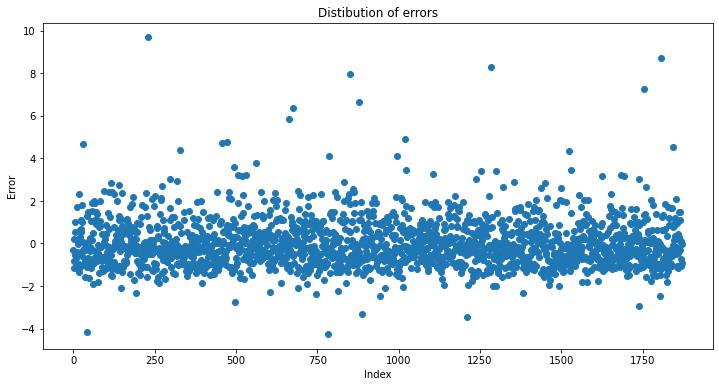

In [ ]:
pred = model.predict(X_train)
errors = Y_test - Y_prediction

plt.figure(figsize = (12,6))
plt.scatter(list(range(len(errors))),errors);
plt.title("Distibution of errors")
plt.ylabel('Error');
plt.xlabel('Index');
plt.show();

In [ ]:
model.score(X_train,Y_train), model.score(X_test,Y_test)

(0.9771120210319097, 0.9763310404686592)

Very interesting how high score is in each set

In [ ]:
#L1 regularization
Lasso_reg = Lasso(alpha=50, max_iter=100, tol=0.1)
Lasso_reg.fit(X_train, Y_train)

Lasso(alpha=50, max_iter=100, tol=0.1)

In [ ]:
Lasso_reg.score(X_train,Y_train), Lasso_reg.score(X_test,Y_test)
#Not large difference

(0.9642998152502913, 0.9632905502596343)

In [ ]:
#L2 regularization
Ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
Ridge_reg.fit(X_train, Y_train)

Ridge(alpha=50, max_iter=100, tol=0.1)

In [ ]:
Ridge_reg.score(X_train,Y_train), Ridge_reg.score(X_test,Y_test)
#Again, not big difference, but better than L1

(0.9770704031363293, 0.9763069534778237)

In [ ]:
#Elastic Net regularization (L1 and L2 combined)
ElasticNet_reg = ElasticNet(alpha=50, max_iter=100, tol=0.1)
ElasticNet_reg.fit(X_train, Y_train)

ElasticNet(alpha=50, max_iter=100, tol=0.1)

In [ ]:
ElasticNet_reg.score(X_train,Y_train), Ridge_reg.score(X_test,Y_test)
#There it works better on test

(0.9635125218411499, 0.9763069534778237)

In [ ]:
#hyperparameters tuning
max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10, 210, 10)
param_dict = dict(max_features = max_features_range, n_estimators = n_estimators_range)
tun = GridSearchCV(estimator = model, param_grid = param_dict, cv = 5)

In [ ]:
tun.fit(X_train, Y_train)

ValueError: Invalid parameter max_features for estimator LinearRegression(normalize='Boolean'). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
model.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

I don't understand why invalid parameter max_features for estimator because I set array of 1 to 5 and model.get_params().keys() 
is also 1 to 5.

    That's all. Feel free to leave as much comments as needs. Have a wonderful day!